[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def linf_distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def l1_distance((a,b),(x,y)):
  return abs(a-x)+abs(b-y)
def displacement(initial,terminal):
  return (terminal[0]-initial[0], terminal[1]-initial[1])
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
  
class Agents:
  
  def __init__(self,L=5,scale=5):
    self.grid_shape = (scale*L, scale*L)
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    self.template_coordinates = get_coordinates(template_array)
    self.agent_coordinates = get_coordinates(agents_array)
    self.activity = [True for _ in self.agent_coordinates]
    self.activity[-1] = False # source agent
    self.direction = [(1,0) for _ in self.agent_coordinates]
    self.update_neighbors()
    self.log = []
  
  def plot(self,highlight_agents_by_index=[],contrast=0.666):
    grid = np.zeros(self.grid_shape)
    for p in self.template_coordinates:
      grid[p]=1-contrast
    for p in self.agent_coordinates:
      grid[p] = 1
    for i in highlight_agents_by_index:
      grid[self.agent_coordinates[i]] = 1+contrast
    plt.imshow(grid)
    plt.grid(False)
    plt.show()
  
  def update_neighbors(self):
    def get_neighbors(i):
      p0 = self.agent_coordinates[i]
      return [j for j,p in enumerate(self.agent_coordinates) if linf_distance(p0,p)==1 and i!=j]
    
    self.neighbors = [get_neighbors(i) for i in range(len(self.agent_coordinates))]
  
  def surroundings(self,i):
    (x0,y0) = self.agent_coordinates[i]
    coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    ans = [{'coordinates': (x,y),
            'is_unoccupied': (x,y) not in self.agent_coordinates,
            'is_in_template': (x,y) in self.template_coordinates,
            'is_in_grid': x in range(self.grid_shape[0]) and y in range(self.grid_shape[1])} for (x,y) in coordinates]
    return ans
  
  def edgefollows(self,i):
    #  x  x  x    x  x  o*   x  x  x    x  x  o*   x  o* o
    #  x     o*   x     o    o* o  o*   o*    o    o*    o
    #  o* o  o    o* o  o    o  o  o    o  o  o    o  o  o
    surr = self.surroundings(i)
    o = [s['is_unoccupied'] for s in surr]
    ans = []
    for k in range(8):
      o0, o1, o2, o3, o4, o5, o6, o7 = o[(k+0)%8], o[(k+1)%8], o[(k+2)%8], o[(k+3)%8], o[(k+4)%8], o[(k+5)%8], o[(k+6)%8], o[(k+7)%8]
      x4, x5, x6, x7 = not o4, not o5, not o6, not o7
      if o0 and o1 and o2 and o3:
        if x4 and x5 and x6 and x7:
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates']]
          break
        elif o4 and x5 and x6 and x7:
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
          break
        elif o4 and o5 and x6 and x7:
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+5)%8]['coordinates']]
          break
        elif o4 and o5 and o6 and x7:
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
          
    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    return ans
    
  def update_activity_direction_coordinates(self,i):
    def prospective_location(i):
      (x0,y0) = self.agent_coordinates[i]
      (dx,dy) = self.direction[i]
      (x,y) = (x0+dx,y0+dy)
      return (x,y)
    def choose(plist):
      def linf_distance_to_template(p):
        return min([linf_distance(p,t) for t in self.template_coordinates])
      def angle(i,p):
        p_direction = displacement(self.agent_coordinates[i],p)
        return l1_distance(self.direction[i],p_direction)
      if len(plist) == 1:
        return plist[0]
      elif len(plist) >= 2:
        angles = [angle(i,p) for p in plist]
        leastangle = min(angles)
        plist = [plist[j] for j,a in enumerate(angles) if a==leastangle]
        if len(plist) == 1:
          return plist[0]
        else:
          distances = [linf_distance_to_template(p) for p in plist]
          leastdist = min(distances)
          plist = [plist[j] for j,d in enumerate(distances) if d==leastdist]
          if len(plist) == 1:
            return plist[0]
          elif len(plist) >= 2:
            return random.choice(plist)
    def update_activity(i):
      if self.activity[i]:
        p0 = self.agent_coordinates[i]
        p = prospective_location(i)
        if p0 in self.template_coordinates and p not in self.template_coordinates: # turn off if moving forward would leave the shape
          self.activity[i] = False
    
    update_activity(i)
    if self.activity[i]: # forward edge-follow
      p = prospective_location(i)
      plist = self.edgefollows(i)
      if p in plist:
        self.agent_coordinates[i] = p
      elif len(plist)>0: # turn & edge-follow
        p = choose(plist)
        self.direction[i] = displacement(self.agent_coordinates[i],p)
        update_activity(i)
        if self.activity[i]:
          self.agent_coordinates[i] = p
  
  def timestep(self,details=False,computation='parallel'):
    def update_log(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0):
      def arrow(direction):
        # arrows: http://xahlee.info/comp/unicode_arrows.html
        arrowdict = {'(-1, 0)':'🡑',
                    '(-1, 1)':'🡕',
                    '(0, 1)':'🡒',
                    '(1, 1)':'🡖',
                    '(1, 0)':'🡓',
                    '(1, -1)':'🡗',
                    '(0, -1)':'🡐',
                    '(-1, -1)':'🡔'}
        return arrowdict[str(direction)]
      dir0, dir1 = arrow(dir0), arrow(dir1)
      translation_dict = {True:'on',False:'off'}
      activity0, activity1 = translation_dict[activity0], translation_dict[activity1]
      template_string = 'Agent {0}: [{1},{2},{3},{7},{8}]-->[{4},{5},{6}]'
      newstring = template_string.format(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
      self.log.append(newstring)
    def move(i):
      orig_coordinates = self.agent_coordinates[i]
      self.update_activity_direction_coordinates(i)
      self.update_neighbors()
      if self.agent_coordinates[i] == orig_coordinates:
        return False
      else:
        return True
      
    subset = [i for i,a in enumerate(self.activity) if len(self.edgefollows(i))>0 and a==True]
    random.shuffle(subset)
    if computation=='parallel':
      for i in subset:
        p0 = self.agent_coordinates[i]
        dir0 = self.direction[i]
        activity0 = self.activity[i]
        neighbors0 = '_'.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
        edgefollows0 = '_'.join([str(e) for e in self.edgefollows(i)])
        move(i)
        p1 = self.agent_coordinates[i]
        dir1 = self.direction[i]
        activity1 = self.activity[i]
        update_log(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
        if details:
          try:
            print self.log[-1]
          except:
            pass
          self.plot(highlight_agents_by_index=[i])
    elif computation=='series':
      for i in [random.choice(subset)]:
        ans = True
        while ans:
          p0 = self.agent_coordinates[i]
          dir0 = self.direction[i]
          activity0 = self.activity[i]
          neighbors0 = '_'.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
          edgefollows0 = '_'.join([str(e) for e in self.edgefollows(i)])
          ans = move(i)
          p1 = self.agent_coordinates[i]
          dir1 = self.direction[i]
          activity1 = self.activity[i]
          update_log(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
          if details:
            try:
              print self.log[-1]
            except:
              pass
            self.plot(highlight_agents_by_index=[i])   

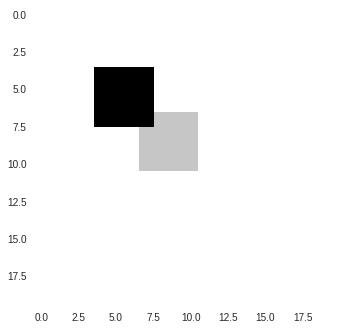

Agent 12: [(7, 4),🡓,on,(6, 4)_(6, 5)_(7, 5),(8, 5)_(6, 3)]-->[(8, 5),🡖,on]


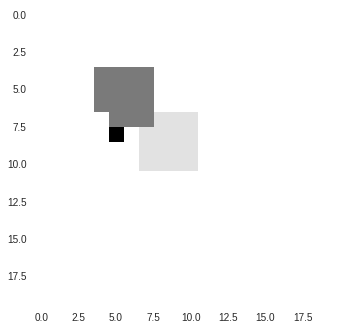

Agent 12: [(8, 5),🡖,on,(7, 5)_(7, 6),(8, 6)_(7, 4)]-->[(8, 6),🡒,on]


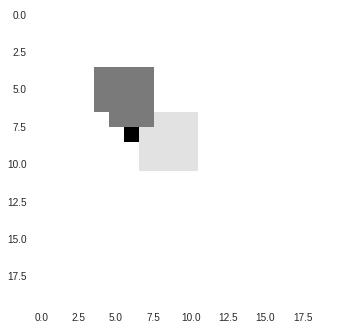

Agent 12: [(8, 6),🡒,on,(7, 5)_(7, 6)_(7, 7),(8, 7)_(8, 5)]-->[(8, 7),🡒,on]


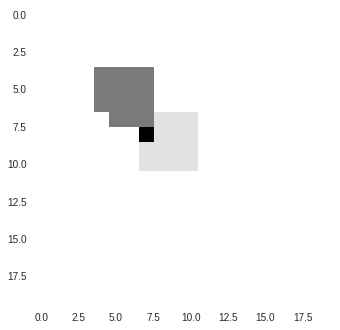

Agent 12: [(8, 7),🡒,on,(7, 6)_(7, 7),(7, 8)_(8, 6)]-->[(7, 8),🡕,on]


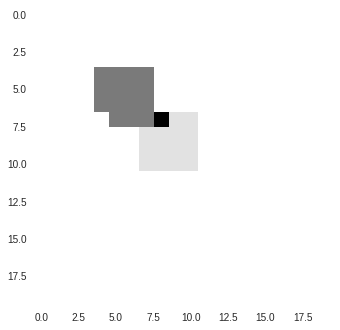

Agent 12: [(7, 8),🡕,on,(6, 7)_(7, 7),(6, 8)_(8, 7)]-->[(7, 8),🡕,off]


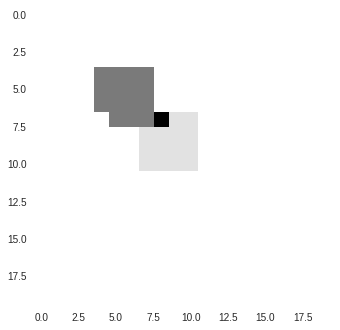

Agent 3: [(4, 7),🡓,on,(4, 6)_(5, 6)_(5, 7),(3, 6)_(5, 8)]-->[(5, 8),🡖,on]


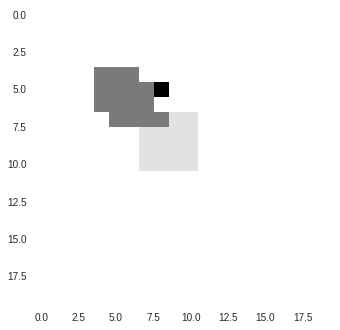

Agent 3: [(5, 8),🡖,on,(5, 7)_(6, 7),(4, 7)_(6, 8)]-->[(6, 8),🡓,on]


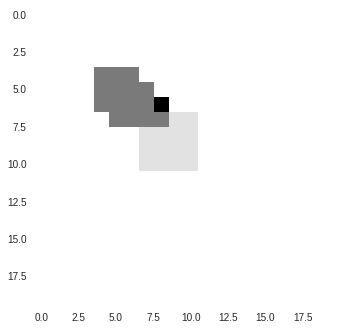

Agent 3: [(6, 8),🡓,on,(5, 7)_(6, 7)_(7, 8)_(7, 7),(5, 8)_(7, 9)]-->[(7, 9),🡖,on]


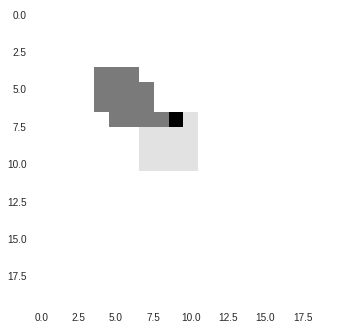

Agent 3: [(7, 9),🡖,on,(7, 8),(6, 8)_(8, 8)]-->[(8, 8),🡗,on]


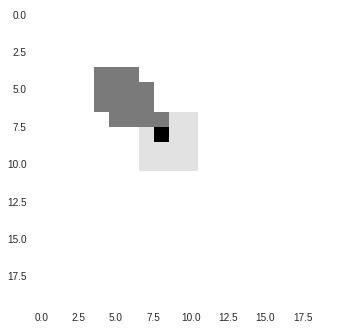

Agent 3: [(8, 8),🡗,on,(7, 8)_(7, 7),(7, 9)_(8, 7)]-->[(8, 7),🡐,on]


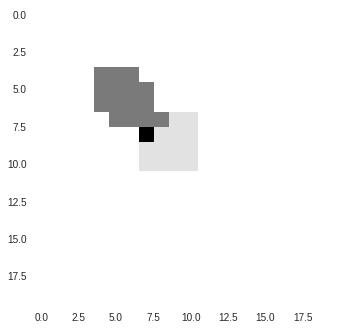

Agent 3: [(8, 7),🡐,on,(7, 8)_(7, 6)_(7, 7),(8, 8)_(8, 6)]-->[(8, 7),🡐,off]


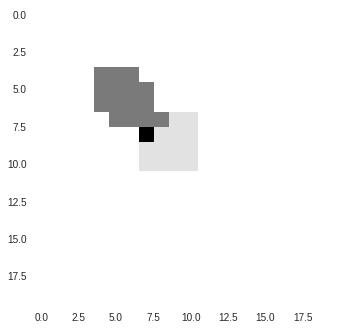

Agent 7: [(5, 7),🡓,on,(4, 6)_(5, 6)_(6, 6)_(6, 7),(4, 7)_(6, 8)]-->[(6, 8),🡖,on]


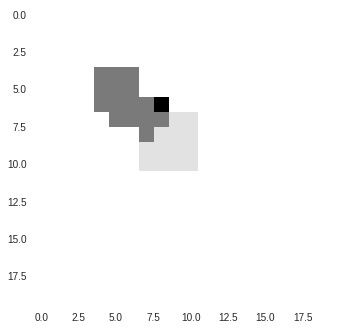

Agent 7: [(6, 8),🡖,on,(6, 7)_(7, 8)_(7, 7),(5, 7)_(7, 9)]-->[(7, 9),🡖,on]


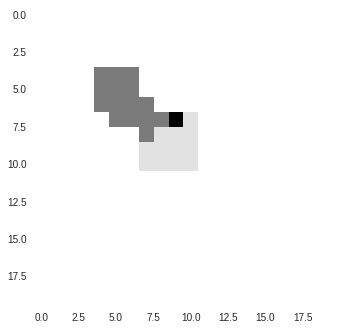

Agent 7: [(7, 9),🡖,on,(7, 8),(6, 8)_(8, 8)]-->[(8, 8),🡗,on]


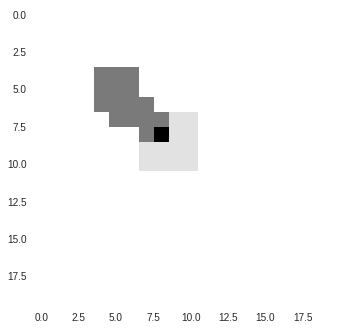

Agent 7: [(8, 8),🡗,on,(8, 7)_(7, 8)_(7, 7),(7, 9)_(9, 7)]-->[(9, 7),🡗,on]


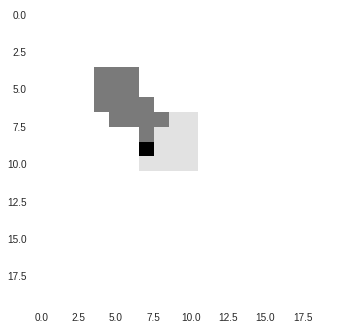

Agent 7: [(9, 7),🡗,on,(8, 7),(8, 8)_(8, 6)]-->[(9, 7),🡗,off]


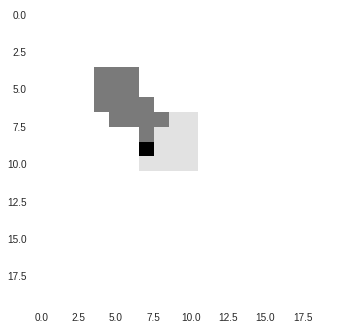

Agent 0: [(4, 4),🡓,on,(4, 5)_(5, 4)_(5, 5),(5, 3)_(3, 5)]-->[(5, 3),🡗,on]


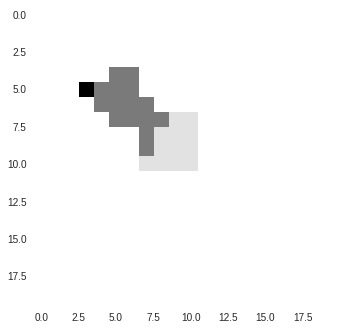

Agent 0: [(5, 3),🡗,on,(5, 4)_(6, 4),(6, 3)_(4, 4)]-->[(6, 3),🡓,on]


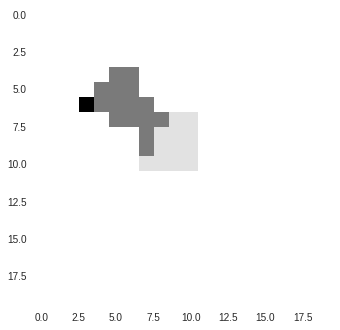

Agent 0: [(6, 3),🡓,on,(5, 4)_(6, 4),(7, 4)_(5, 3)]-->[(7, 4),🡖,on]


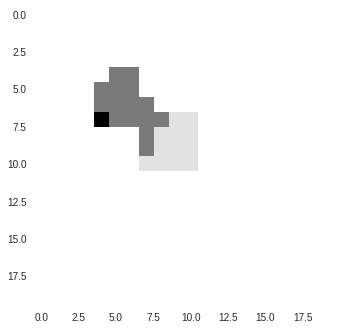

Agent 0: [(7, 4),🡖,on,(6, 4)_(6, 5)_(7, 5),(8, 5)_(6, 3)]-->[(8, 5),🡖,on]


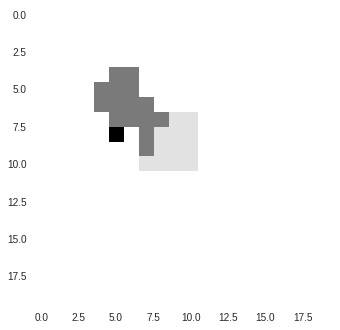

Agent 0: [(8, 5),🡖,on,(7, 5)_(7, 6),(8, 6)_(7, 4)]-->[(8, 6),🡒,on]


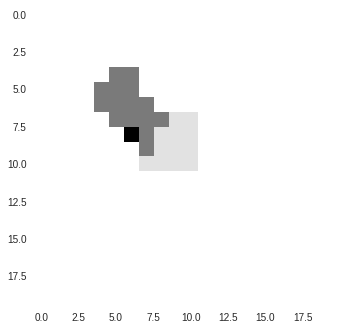

Agent 0: [(8, 6),🡒,on,(8, 7)_(9, 7)_(7, 5)_(7, 6)_(7, 7),]-->[(8, 6),🡒,on]


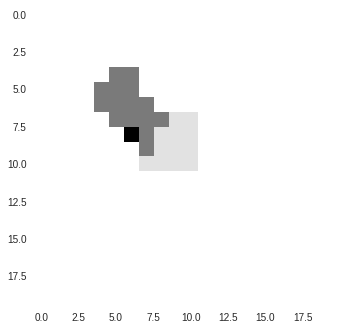

Agent 4: [(5, 4),🡓,on,(4, 5)_(5, 5)_(6, 4)_(6, 5),(6, 3)_(4, 4)]-->[(6, 3),🡗,on]


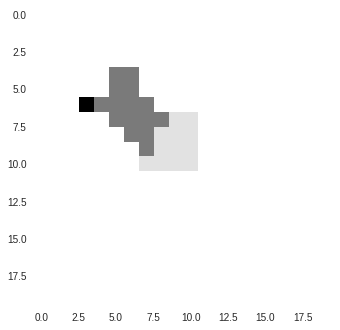

Agent 4: [(6, 3),🡗,on,(6, 4),(7, 4)_(5, 4)]-->[(7, 4),🡖,on]


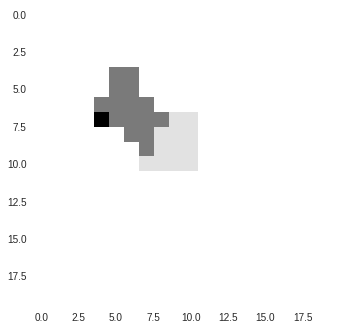

Agent 4: [(7, 4),🡖,on,(6, 4)_(6, 5)_(7, 5),(8, 5)_(6, 3)]-->[(8, 5),🡖,on]


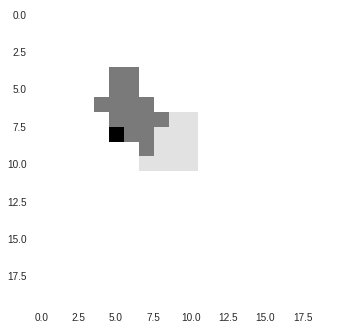

Agent 4: [(8, 5),🡖,on,(8, 6)_(7, 5)_(7, 6),(9, 6)_(7, 4)]-->[(9, 6),🡖,on]


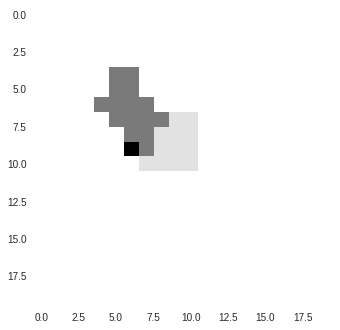

Agent 4: [(9, 6),🡖,on,(8, 6)_(8, 7)_(9, 7),(10, 7)_(8, 5)]-->[(10, 7),🡖,on]


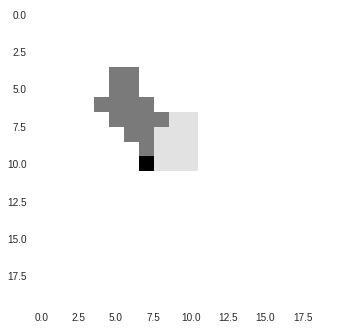

Agent 4: [(10, 7),🡖,on,(9, 7),(9, 8)_(9, 6)]-->[(10, 7),🡖,off]


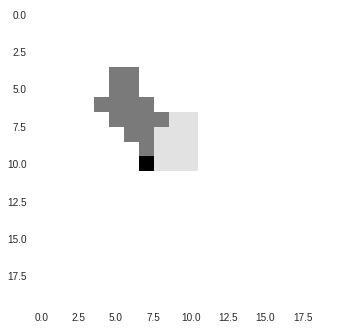

Agent 8: [(6, 4),🡓,on,(5, 5)_(6, 5)_(7, 5),(7, 4)_(5, 4)]-->[(7, 4),🡓,on]


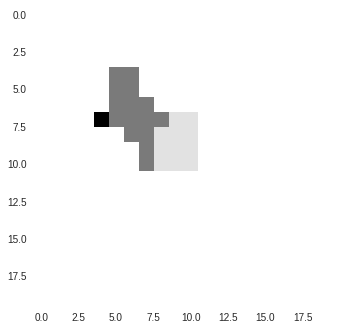

Agent 8: [(7, 4),🡓,on,(6, 5)_(7, 5),(8, 5)_(6, 4)]-->[(8, 5),🡖,on]


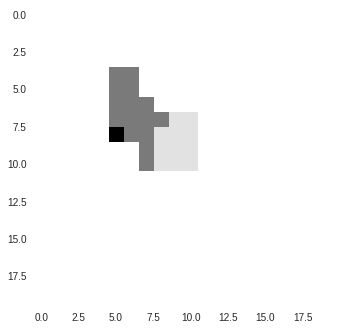

Agent 8: [(8, 5),🡖,on,(8, 6)_(7, 5)_(7, 6),(9, 6)_(7, 4)]-->[(9, 6),🡖,on]


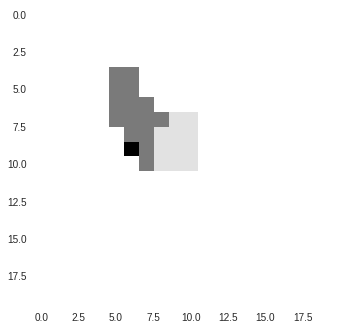

Agent 8: [(9, 6),🡖,on,(8, 6)_(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 5)]-->[(10, 6),🡓,on]


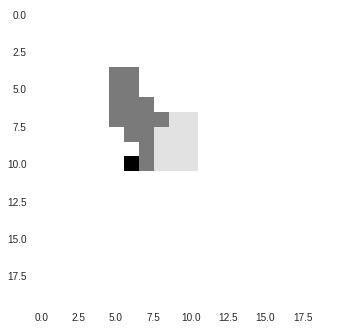

Agent 8: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


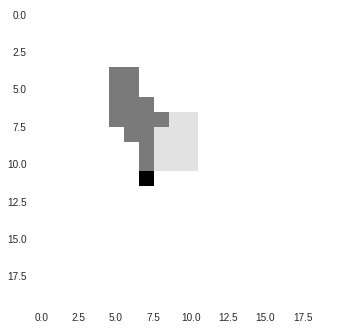

Agent 8: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


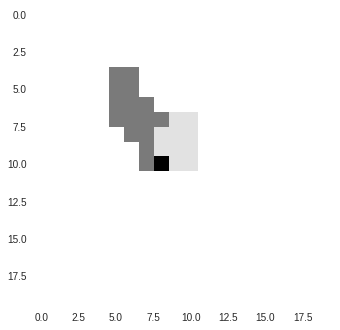

Agent 8: [(10, 8),🡕,on,(10, 7)_(9, 7),(9, 8)_(11, 7)]-->[(9, 8),🡑,on]


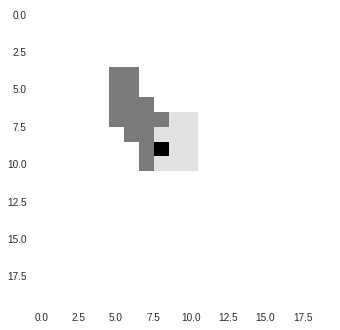

Agent 8: [(9, 8),🡑,on,(8, 7)_(10, 7)_(9, 7),(8, 8)_(10, 8)]-->[(8, 8),🡑,on]


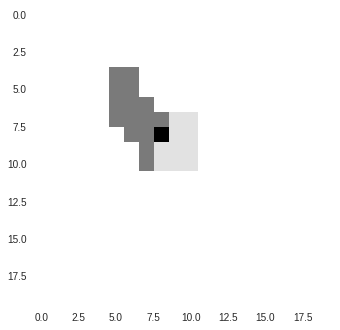

Agent 8: [(8, 8),🡑,on,(8, 7)_(9, 7)_(7, 8)_(7, 7),(7, 9)_(9, 8)]-->[(7, 9),🡕,on]


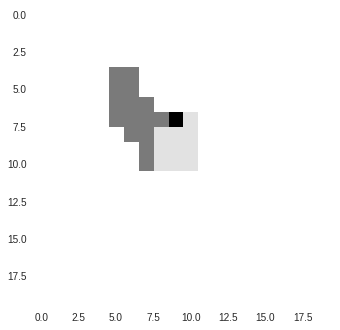

Agent 8: [(7, 9),🡕,on,(7, 8),(6, 8)_(8, 8)]-->[(7, 9),🡕,off]


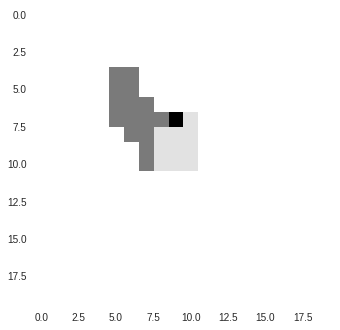

Agent 2: [(4, 6),🡓,on,(4, 5)_(5, 5)_(5, 6),(3, 5)_(5, 7)]-->[(5, 7),🡖,on]


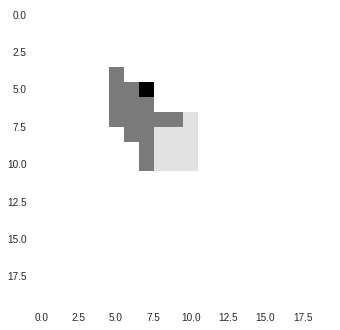

Agent 2: [(5, 7),🡖,on,(5, 6)_(6, 6)_(6, 7),(4, 6)_(6, 8)]-->[(6, 8),🡖,on]


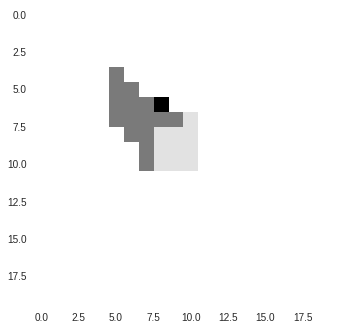

Agent 2: [(6, 8),🡖,on,(7, 9)_(6, 7)_(7, 8)_(7, 7),(5, 7)_(6, 9)]-->[(6, 9),🡒,on]


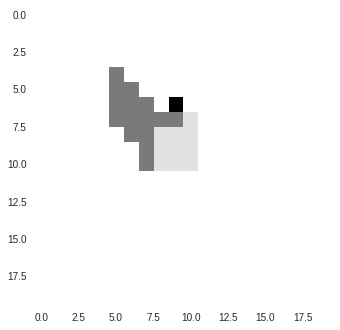

Agent 2: [(6, 9),🡒,on,(7, 9)_(7, 8),(6, 8)_(7, 10)]-->[(7, 10),🡖,on]


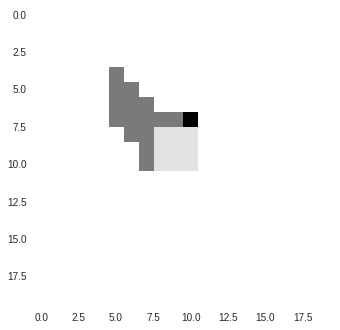

Agent 2: [(7, 10),🡖,on,(7, 9),(6, 9)_(8, 9)]-->[(7, 10),🡖,off]


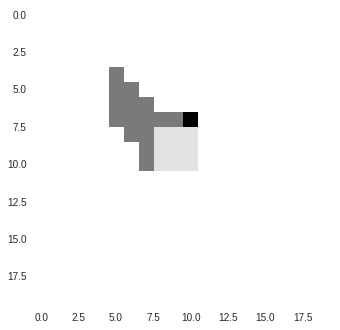

Agent 1: [(4, 5),🡓,on,(5, 5)_(5, 6),(5, 4)_(4, 6)]-->[(5, 4),🡗,on]


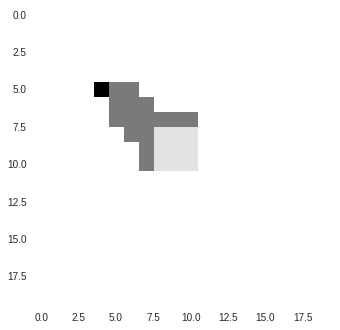

Agent 1: [(5, 4),🡗,on,(5, 5)_(6, 5),(6, 4)_(4, 5)]-->[(6, 4),🡓,on]


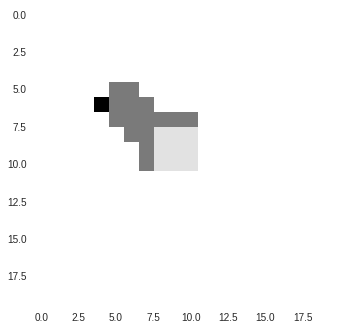

Agent 1: [(6, 4),🡓,on,(5, 5)_(6, 5)_(7, 5),(7, 4)_(5, 4)]-->[(7, 4),🡓,on]


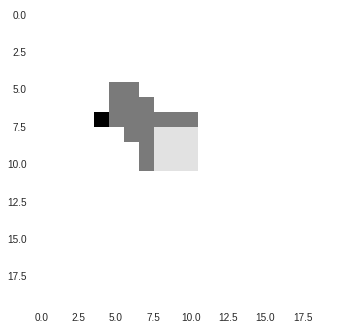

Agent 1: [(7, 4),🡓,on,(6, 5)_(7, 5),(8, 5)_(6, 4)]-->[(8, 5),🡖,on]


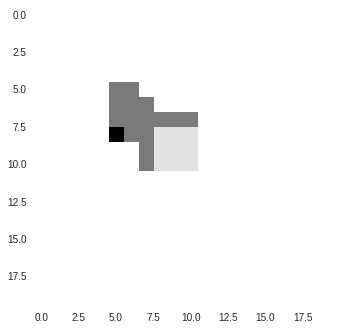

Agent 1: [(8, 5),🡖,on,(8, 6)_(7, 5)_(7, 6),(9, 6)_(7, 4)]-->[(9, 6),🡖,on]


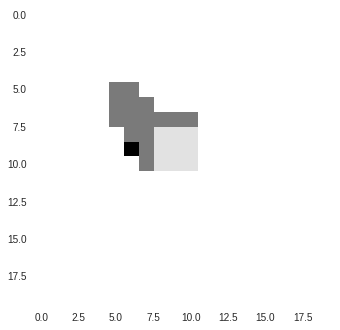

Agent 1: [(9, 6),🡖,on,(8, 6)_(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 5)]-->[(10, 6),🡓,on]


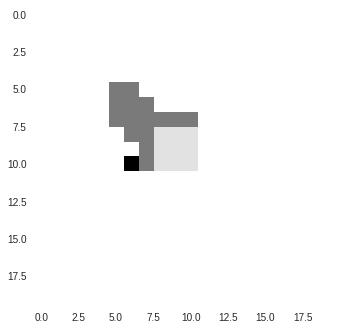

Agent 1: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


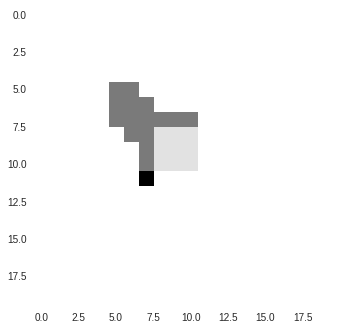

Agent 1: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


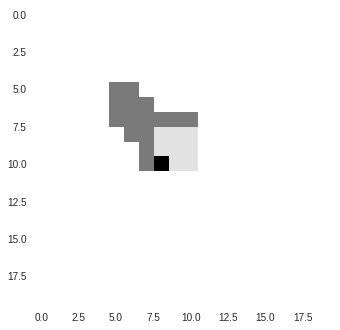

Agent 1: [(10, 8),🡕,on,(10, 7)_(9, 7),(9, 8)_(11, 7)]-->[(9, 8),🡑,on]


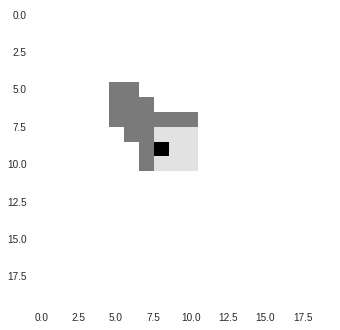

Agent 1: [(9, 8),🡑,on,(8, 7)_(10, 7)_(9, 7),(8, 8)_(10, 8)]-->[(8, 8),🡑,on]


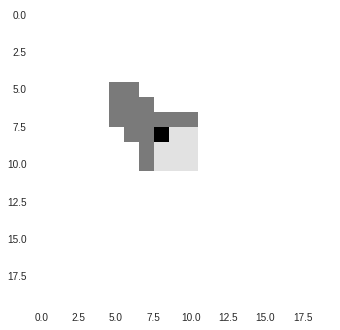

Agent 1: [(8, 8),🡑,on,(8, 7)_(9, 7)_(7, 9)_(7, 8)_(7, 7),]-->[(8, 8),🡑,on]


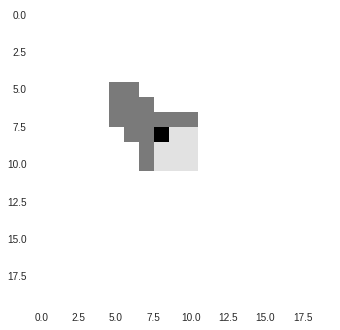

Agent 5: [(5, 5),🡓,on,(5, 6)_(6, 5)_(6, 6),(6, 4)_(4, 6)]-->[(6, 4),🡗,on]


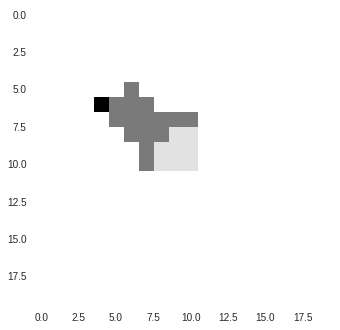

Agent 5: [(6, 4),🡗,on,(6, 5)_(7, 5),(7, 4)_(5, 5)]-->[(7, 4),🡓,on]


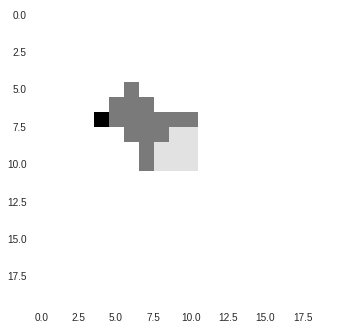

Agent 5: [(7, 4),🡓,on,(6, 5)_(7, 5),(8, 5)_(6, 4)]-->[(8, 5),🡖,on]


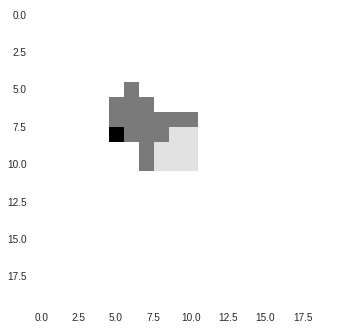

Agent 5: [(8, 5),🡖,on,(8, 6)_(7, 5)_(7, 6),(9, 6)_(7, 4)]-->[(9, 6),🡖,on]


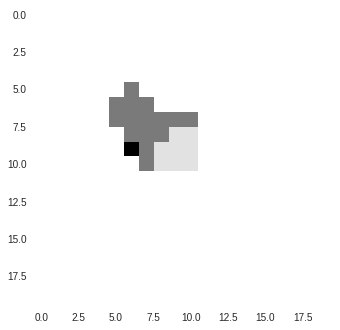

Agent 5: [(9, 6),🡖,on,(8, 6)_(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 5)]-->[(10, 6),🡓,on]


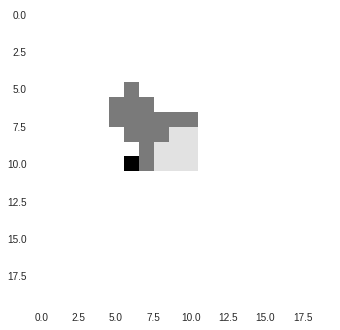

Agent 5: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


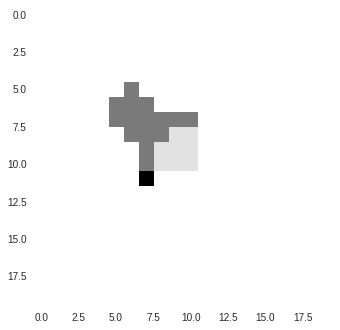

Agent 5: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


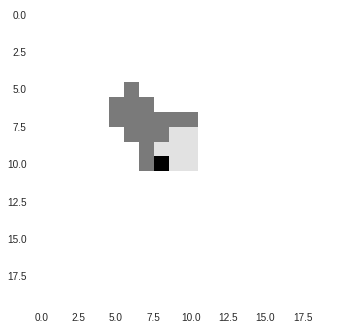

Agent 5: [(10, 8),🡕,on,(10, 7)_(9, 7),(9, 8)_(11, 7)]-->[(9, 8),🡑,on]


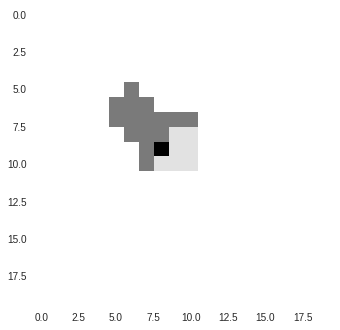

Agent 5: [(9, 8),🡑,on,(8, 8)_(8, 7)_(10, 7)_(9, 7),(8, 9)_(10, 8)]-->[(8, 9),🡕,on]


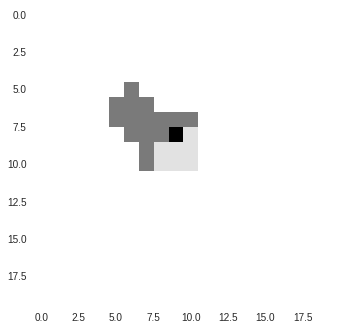

Agent 5: [(8, 9),🡕,on,(8, 8)_(7, 10)_(7, 9)_(7, 8),(8, 10)_(9, 8)]-->[(8, 10),🡒,on]


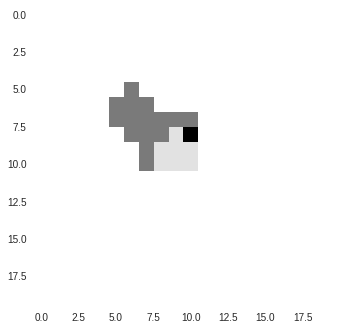

Agent 5: [(8, 10),🡒,on,(7, 10)_(7, 9),(7, 11)_(8, 9)]-->[(8, 10),🡒,off]


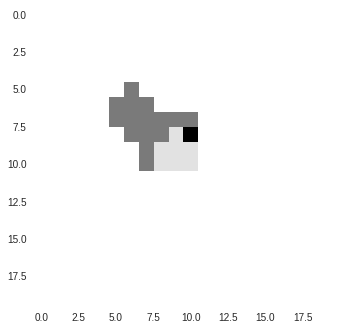

Agent 9: [(6, 5),🡓,on,(5, 6)_(6, 6)_(7, 5)_(7, 6),(7, 4)_(5, 5)]-->[(7, 4),🡗,on]


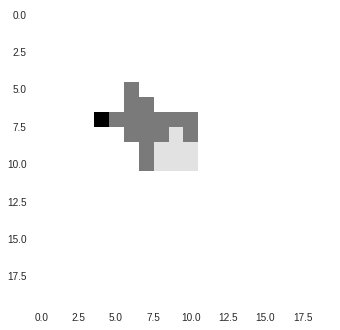

Agent 9: [(7, 4),🡗,on,(7, 5),(8, 5)_(6, 5)]-->[(8, 5),🡖,on]


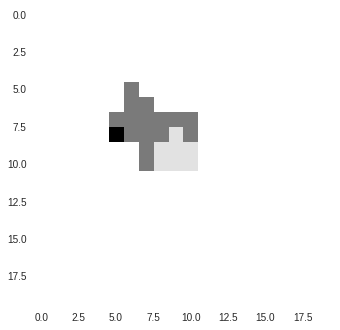

Agent 9: [(8, 5),🡖,on,(8, 6)_(7, 5)_(7, 6),(9, 6)_(7, 4)]-->[(9, 6),🡖,on]


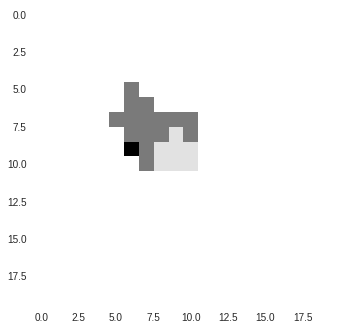

Agent 9: [(9, 6),🡖,on,(8, 6)_(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 5)]-->[(10, 6),🡓,on]


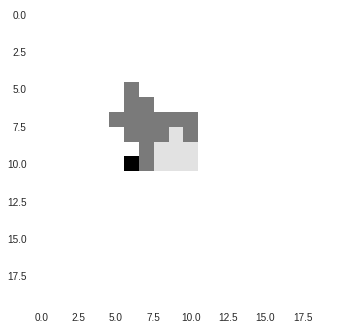

Agent 9: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


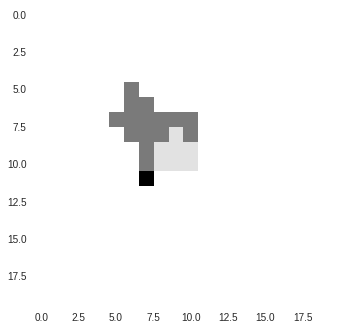

Agent 9: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


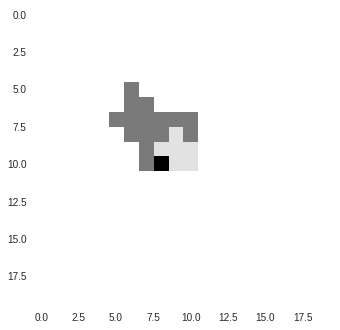

Agent 9: [(10, 8),🡕,on,(10, 7)_(9, 7),(9, 8)_(11, 7)]-->[(9, 8),🡑,on]


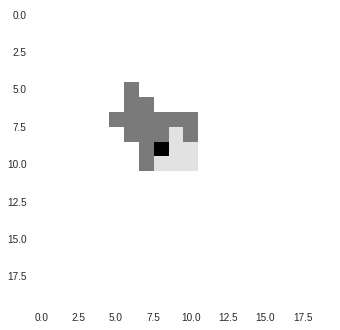

Agent 9: [(9, 8),🡑,on,(8, 8)_(8, 7)_(10, 7)_(9, 7),(8, 9)_(10, 8)]-->[(8, 9),🡕,on]


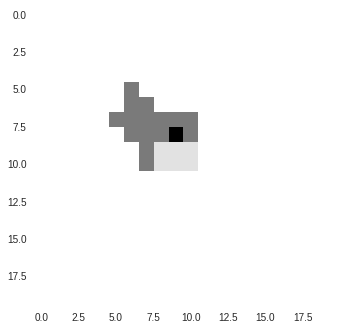

Agent 9: [(8, 9),🡕,on,(8, 8)_(7, 10)_(8, 10)_(7, 9)_(7, 8),]-->[(8, 9),🡕,on]


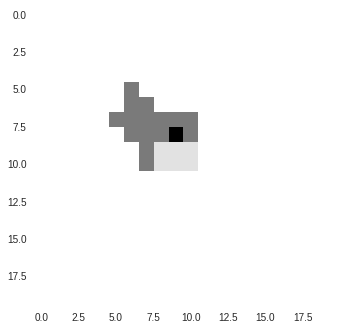

Agent 13: [(7, 5),🡓,on,(8, 6)_(6, 6)_(7, 6),(8, 5)_(6, 5)]-->[(8, 5),🡓,on]


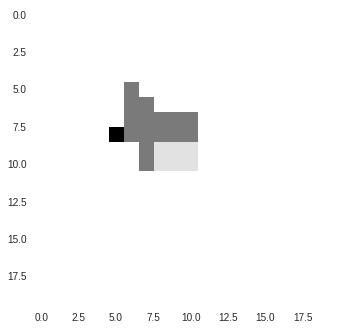

Agent 13: [(8, 5),🡓,on,(8, 6)_(7, 6),(9, 6)_(7, 5)]-->[(9, 6),🡖,on]


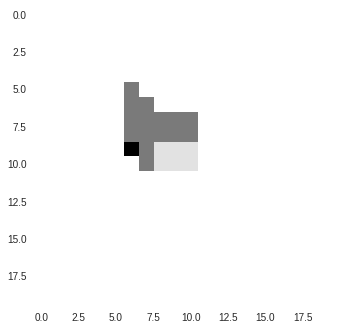

Agent 13: [(9, 6),🡖,on,(8, 6)_(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 5)]-->[(10, 6),🡓,on]


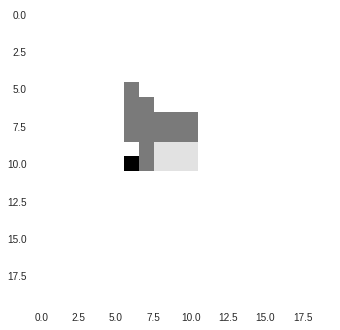

Agent 13: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


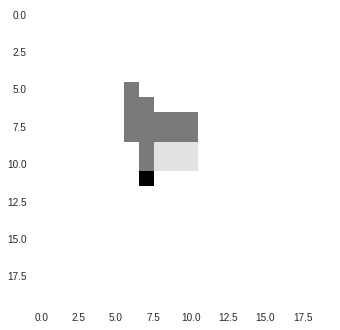

Agent 13: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


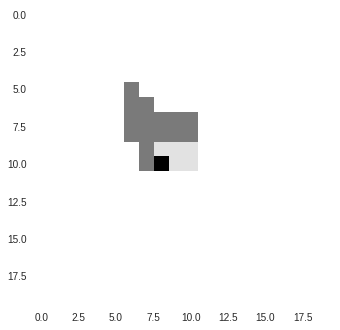

Agent 13: [(10, 8),🡕,on,(10, 7)_(9, 7),(9, 8)_(11, 7)]-->[(9, 8),🡑,on]


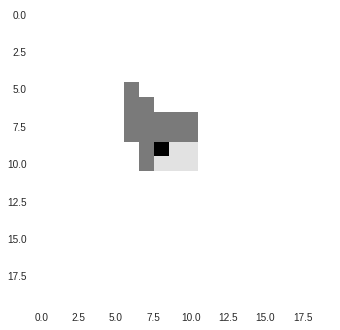

Agent 13: [(9, 8),🡑,on,(8, 8)_(8, 7)_(10, 7)_(9, 7)_(8, 9),]-->[(9, 8),🡑,on]


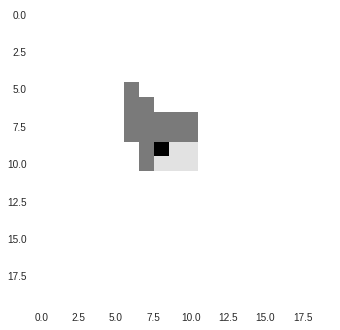

Agent 0: [(8, 6),🡒,on,(8, 7)_(9, 7)_(7, 6)_(7, 7),(9, 6)_(7, 5)]-->[(9, 6),🡓,on]


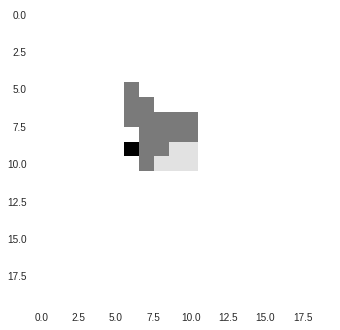

Agent 0: [(9, 6),🡓,on,(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 6)]-->[(10, 6),🡓,on]


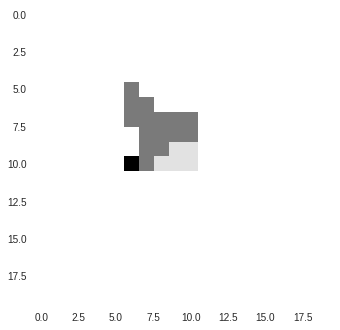

Agent 0: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


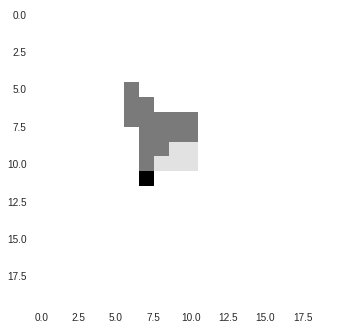

Agent 0: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


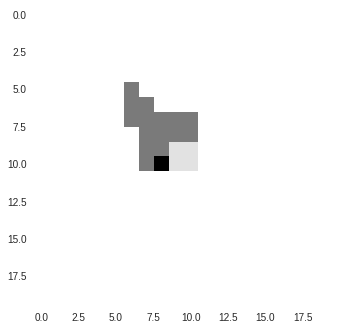

Agent 0: [(10, 8),🡕,on,(10, 7)_(9, 7)_(9, 8),(9, 9)_(11, 7)]-->[(9, 9),🡕,on]


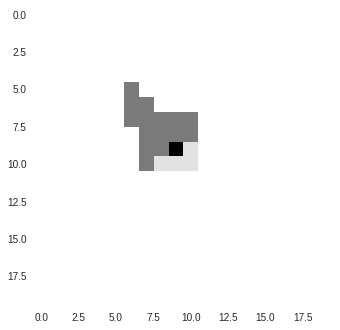

Agent 0: [(9, 9),🡕,on,(8, 8)_(8, 10)_(8, 9)_(9, 8),(9, 10)_(10, 8)]-->[(9, 10),🡒,on]


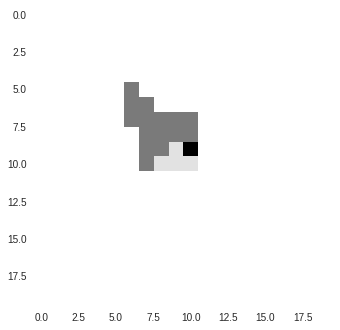

Agent 0: [(9, 10),🡒,on,(8, 10)_(8, 9),(8, 11)_(9, 9)]-->[(9, 10),🡒,off]


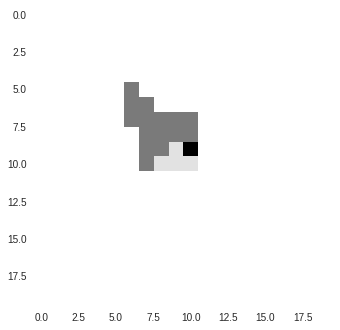

Agent 6: [(5, 6),🡓,on,(6, 6)_(6, 7),(6, 5)_(5, 7)]-->[(6, 5),🡗,on]


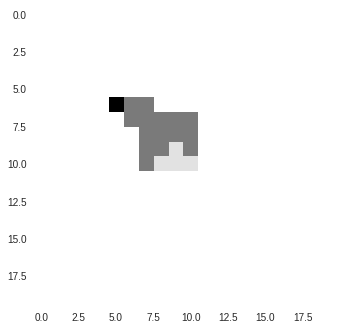

Agent 6: [(6, 5),🡗,on,(6, 6)_(7, 6),(7, 5)_(5, 6)]-->[(7, 5),🡓,on]


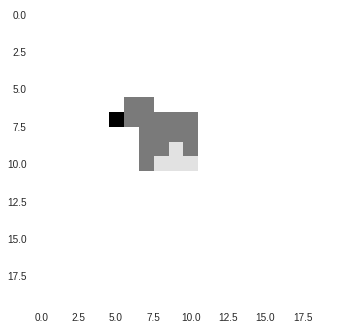

Agent 6: [(7, 5),🡓,on,(6, 6)_(7, 6),(8, 6)_(6, 5)]-->[(8, 6),🡖,on]


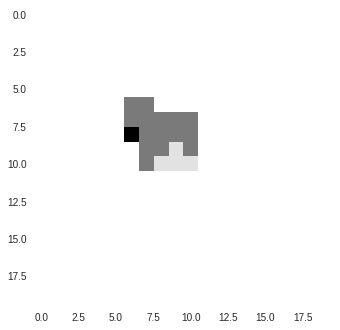

Agent 6: [(8, 6),🡖,on,(8, 7)_(9, 7)_(7, 6)_(7, 7),(9, 6)_(7, 5)]-->[(9, 6),🡓,on]


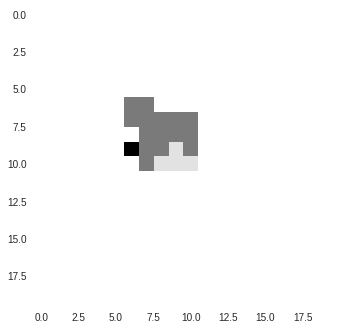

Agent 6: [(9, 6),🡓,on,(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 6)]-->[(10, 6),🡓,on]


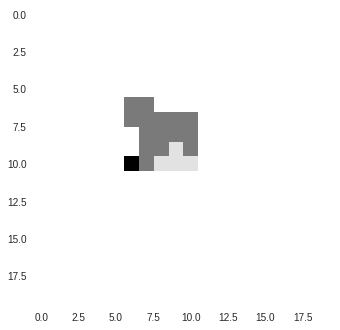

Agent 6: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


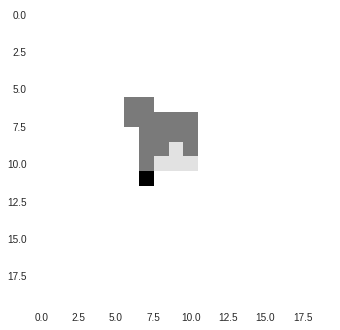

Agent 6: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


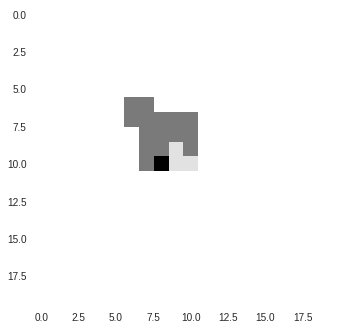

Agent 6: [(10, 8),🡕,on,(10, 7)_(9, 7)_(9, 8),(9, 9)_(11, 7)]-->[(9, 9),🡕,on]


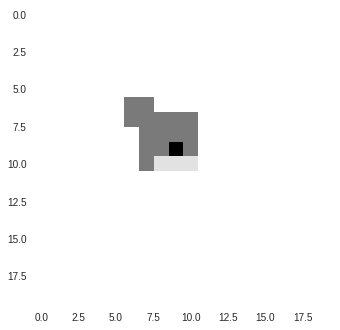

Agent 6: [(9, 9),🡕,on,(9, 10)_(8, 8)_(8, 10)_(8, 9)_(9, 8),]-->[(9, 9),🡕,on]


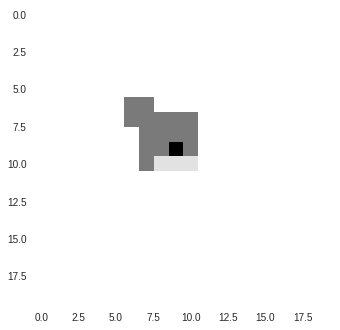

Agent 14: [(7, 6),🡓,on,(8, 7)_(6, 6)_(6, 7)_(7, 7),(8, 6)_(6, 5)]-->[(8, 6),🡓,on]


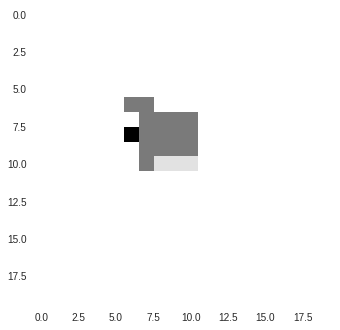

Agent 14: [(8, 6),🡓,on,(8, 7)_(9, 7)_(7, 7),(9, 6)_(7, 6)]-->[(9, 6),🡓,on]


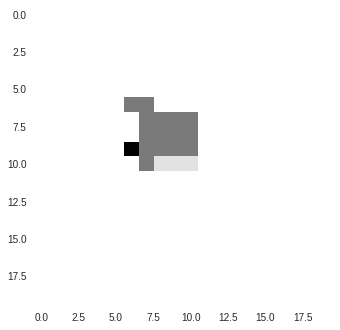

Agent 14: [(9, 6),🡓,on,(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 6)]-->[(10, 6),🡓,on]


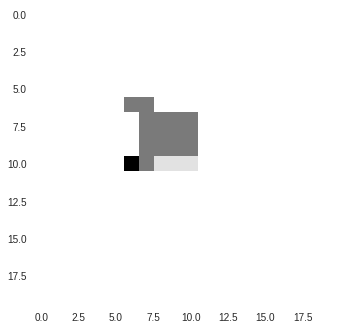

Agent 14: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


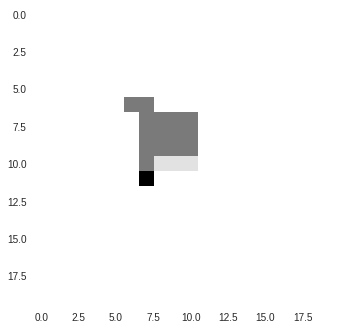

Agent 14: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


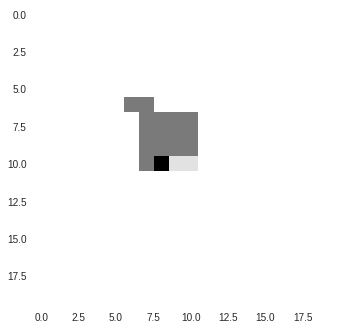

Agent 14: [(10, 8),🡕,on,(10, 7)_(9, 9)_(9, 7)_(9, 8),(10, 9)_(11, 7)]-->[(10, 9),🡒,on]


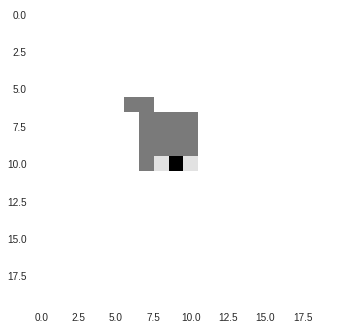

Agent 14: [(10, 9),🡒,on,(9, 10)_(9, 9)_(9, 8),(10, 10)_(10, 8)]-->[(10, 10),🡒,on]


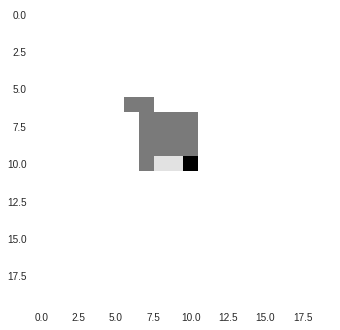

Agent 14: [(10, 10),🡒,on,(9, 10)_(9, 9),(9, 11)_(10, 9)]-->[(10, 10),🡒,off]


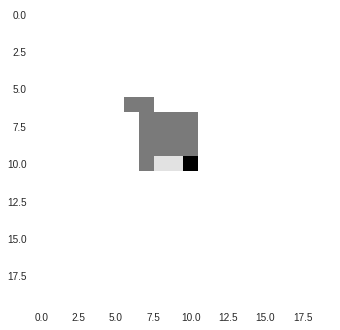

Agent 10: [(6, 6),🡓,on,(6, 7)_(7, 7),(7, 6)_(5, 7)]-->[(7, 6),🡓,on]


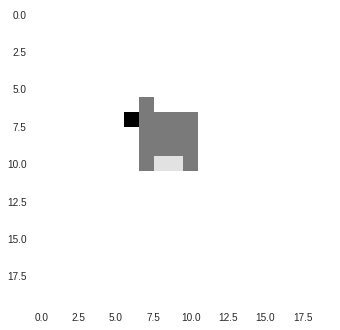

Agent 10: [(7, 6),🡓,on,(8, 7)_(6, 7)_(7, 7),(8, 6)_(6, 6)]-->[(8, 6),🡓,on]


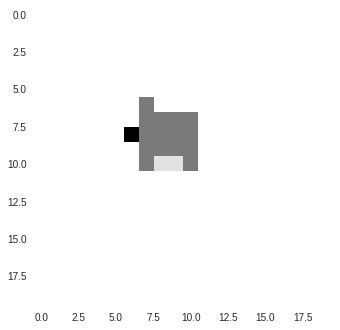

Agent 10: [(8, 6),🡓,on,(8, 7)_(9, 7)_(7, 7),(9, 6)_(7, 6)]-->[(9, 6),🡓,on]


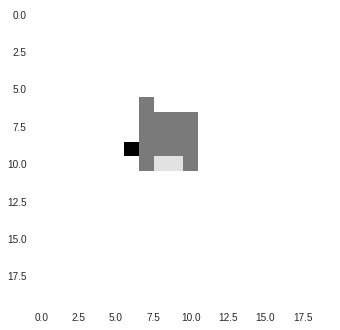

Agent 10: [(9, 6),🡓,on,(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 6)]-->[(10, 6),🡓,on]


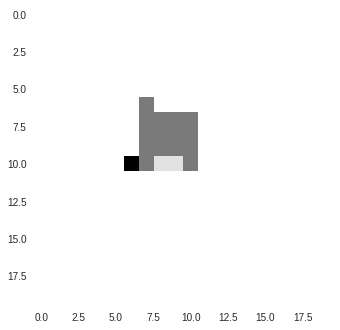

Agent 10: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


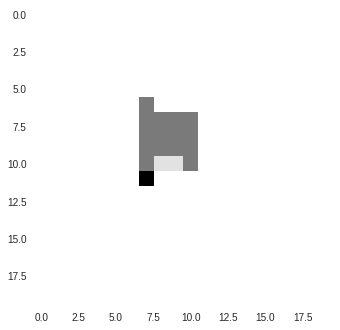

Agent 10: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


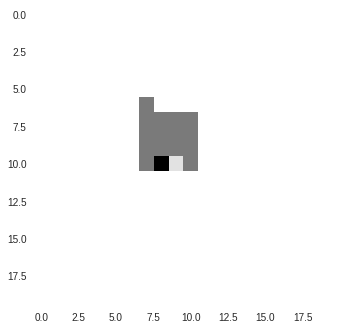

Agent 10: [(10, 8),🡕,on,(10, 7)_(9, 9)_(9, 7)_(9, 8),(10, 9)_(11, 7)]-->[(10, 9),🡒,on]


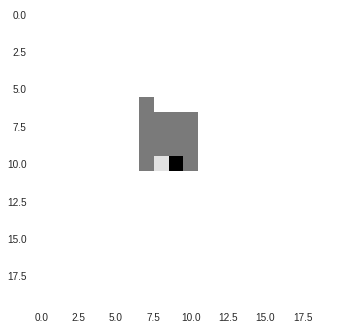

Agent 10: [(10, 9),🡒,on,(9, 10)_(9, 9)_(9, 8)_(10, 10),(11, 10)_(10, 8)]-->[(10, 9),🡖,off]


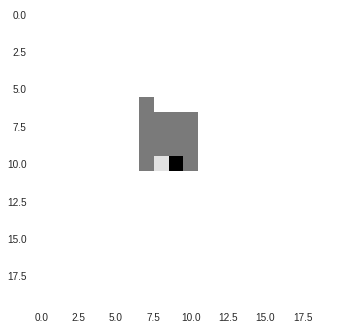

Agent 11: [(6, 7),🡓,on,(7, 8)_(7, 7),(7, 6)_(6, 8)]-->[(7, 6),🡗,on]


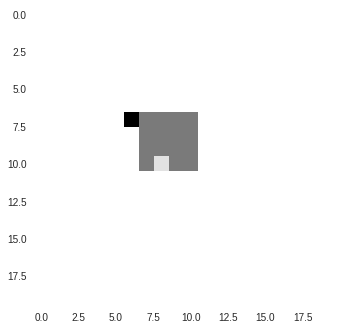

Agent 11: [(7, 6),🡗,on,(8, 7)_(7, 7),(8, 6)_(6, 7)]-->[(8, 6),🡓,on]


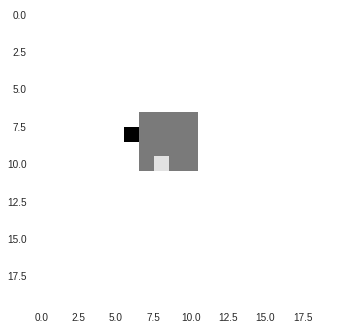

Agent 11: [(8, 6),🡓,on,(8, 7)_(9, 7)_(7, 7),(9, 6)_(7, 6)]-->[(9, 6),🡓,on]


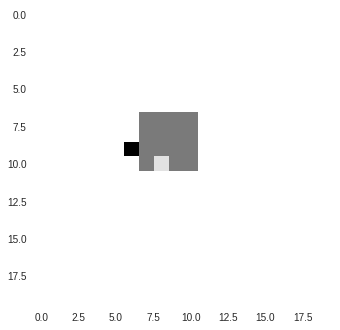

Agent 11: [(9, 6),🡓,on,(8, 7)_(10, 7)_(9, 7),(10, 6)_(8, 6)]-->[(10, 6),🡓,on]


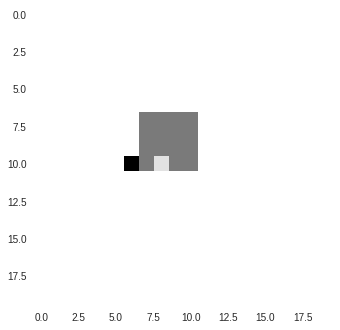

Agent 11: [(10, 6),🡓,on,(10, 7)_(9, 7),(11, 7)_(9, 6)]-->[(11, 7),🡖,on]


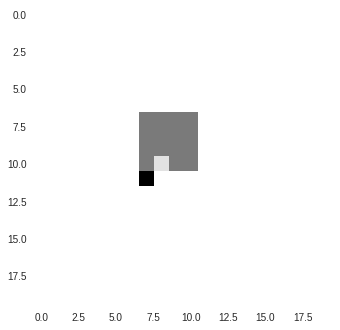

Agent 11: [(11, 7),🡖,on,(10, 7),(10, 8)_(10, 6)]-->[(10, 8),🡕,on]


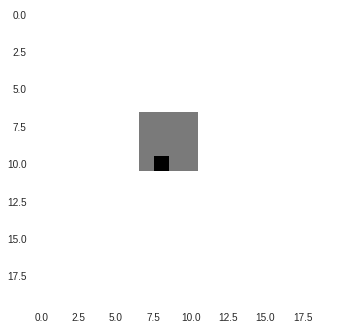

Agent 11: [(10, 8),🡕,on,(10, 7)_(9, 9)_(9, 7)_(10, 9)_(9, 8),]-->[(10, 8),🡕,on]


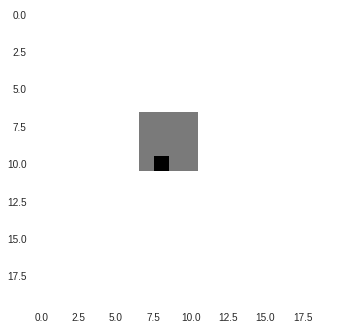

IndexError: ignored

In [23]:
a = Agents(L=4)
a.plot()
for i in range(20):
  a.timestep(details=True,computation='series')
  #if i%10==0:
  #  a.plot()

In [8]:
a.agent_coordinates

[(4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [31]:
print arrowdict[str((1,0))]

KeyError: ignored

FROM BEFORE:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
  
class Agents:
  
  def __init__(self,L=10,scale=5):
    self.grid_shape = (scale*L, scale*L)
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    self.template_coordinates = get_coordinates(template_array)
    
    self.agent_coordinates = get_coordinates(agents_array)
    #self.estimated_coordinates = self.true_coordinates
    self.orientation = [(1,0) for _ in self.true_coordinates]
    self.update_neighbors()
    
    #prod = [i*j for (i,j) in self.agent_coordinates]
    #maxprod = max(prod)
    #self.is_source = [bool(p == maxprod) for p in prod]
    #self.update_gradient()  
    self.log = []
  
  def plot(self,highlight=[]):
    grid = np.zeros(self.grid_shape)
    for p in self.template_coordinates:
      grid[p]=0.33
    #max_gradient = max(self.gradient)
    for i,p in enumerate(self.agent_coordinates):
      grid[p] = 1#1+ 2*(1 - float(max_gradient - self.gradient[i])/max_gradient)
    for i in highlight:
      grid[self.agent_coordinates[i]] = 2
    plt.imshow(grid)
    plt.grid(False)
    plt.show()
  
  def get_neighbors(self,i):
    center = self.agent_coordinates[i]
    return [j for j,p in enumerate(self.agent_coordinates) if distance(center,p)==1 and i!=j]
  def update_neighbors(self):
    self.neighbors = [self.get_neighbors(i) for i in range(len(self.agent_coordinates))]
  
  #def neighbor_gradient_max(self,i):
  #  return max([self.gradient[j] for j in self.neighbors[i]])
  #def update_gradient(self):
  #  self.gradient = ['' for _ in self.agent_coordinates]
  #  i_source = self.is_source.index(True)
  #  self.gradient[i_source] = 0
  #  for j in self.neighbors[i_source]:
  #    self.gradient[j] = 1
  #  while '' in self.gradient:
  #    for i,g in enumerate(self.gradient):
  #      if g=='':
  #        min_gradient_in_neighbors = 9*10**10
  #        should_assign_gradient_value = False
  #        for j in self.neighbors[i]:
  #          if self.gradient[j] != '':
  #            min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
  #            should_assign_gradient_value = True
  #        if should_assign_gradient_value:
  #          self.gradient[i] = 1+min_gradient_in_neighbors
  
  #def get_estimated_coordinates(self,i):
  #  neighbors_estimated_coordinates = [self.estimated_coordinates[j] for j in self.neighbors[i]]
  #  neighbors_estimated_coordinates_x = [p[0] for p in neighbors_estimated_coordinates]
  #  neighbors_estimated_coordinates_y = [p[1] for p in neighbors_estimated_coordinates]
  #  [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
  #  [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
  #  candidate_estimations = list(itertools.product(range(min_x-1,max_x+2),range(min_y-1,max_y+2)))
  #  
  #  def error_estimated_coordinates(p):
  #    errors = [1 - distance(p,p_neighbor) for p_neighbor in neighbors_estimated_coordinates]
  #    return sum([abs(err) for err in errors])
  #  
  #  candidate_estimation_errors = [error_estimated_coordinates(p) for p in candidate_estimations]
  #  optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
  #  estimated_coordinates = random.choice(optimal_estimations)
  #  return estimated_coordinates
  
  #def update_estimated_coordinates(self):
  #  self.estimated_coordinates = [self.get_estimated_coordinates(i) for i in range(len(self.true_coordinates))]
  
  def surroundings(self,i):
    (x0,y0) = self.agent_coordinates[i]
    coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    ans = [{'coordinates': (x,y), 'is_occupied': (x,y) in self.agent_coordinates, 'is_in_template': (x,y) in self.template_coordinates} for (x,y) in coordinates]
  
  def is_on_cornerpiece_or_edge(self,i):
    #  x x o  x x x  x x o  x o o
    #  x   o  o   o  o   o  o   o
    #  o o o  o o o  o o o  o o o
    neighbor_coordinates = [self.agent_coordinates[j] for j in self.neighbors[i]]
    x = [(p in neighbor_coordinates) for p in self.surroundings(i)]
    ans = False
    for k in range(len(is_occupied)):
      if not x[k] and not x[(k+1)%8] and not x[(k+2)%8] and not x[(k+3)%8] and not x[(k+4)%8]:
        if (x[(k+5)%8] and x[(k+6)%8] and x[(k+7)%8]) or (not x[(k+5)%8] and x[(k+6)%8] and x[(k+7)%8]) or (not x[(k+5)%8] and not x[(k+6)%8] and x[(k+7)%8]):
          ans = True
          break
    return ans
  
  def valid_moves(self,i):
    ans = [self.agent_coordinates(i)]
    if self.is_on_cornerpiece_or_edge(i):
      potential_moves = self.surroundings(i)
      for (x,y) in potential_moves:
        if # doesn't break off
        

  def can_move(self,i):
    ans = False
    if self.is_on_cornerpiece_or_edge(i):
      if self.move_stays_in_grid(i):
        
    
    
    occupied = [self.agent_coordinates[j] for j in self.neighbors[i]]
    (x0,y0) = self.agent_coordinates[i]
    (dx,dy) = self.orientation[i]
    (x,y) = self.coordinates_after_move(i)
    surroundings0 = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    surroundings0_unoccupied = [s not in occupied for s in surroundings0]
    surroundings = [(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x-1,y-1),(x-1,y+1),(x+1,y-1),(x+1,y+1)]
    
    
    if not any([self.gradient[j]>self.gradient[i] for j in self.neighbors[i]]): # doesn't have neighbor with greater gradient
      if any([surroundings0_unoccupied[n%8] and surroundings0_unoccupied[(n+1)%8] and surroundings0_unoccupied[(n+2)%8] and surroundings0_unoccupied[(n+3)%8] for n in range(8)]): # has open semicircle    
        if (x,y) not in occupied:
          if any([(p in occupied) for p in surroundings if p != (x0,y0)]): # doesn't break off from the mass
            if x in range(self.grid_shape[0]) and y in range(self.grid_shape[1]): # stays in grid
              if (x0,y0) not in self.template_coordinates or ((x0,y0) in self.template_coordinates and (x,y) in self.template_coordinates): # doesn't exit template
                ans = True
    return ans
  
  def move(self,i):
    def arrow(orientation):
      if orientation == (-1,0):
        return '⇡'
      elif orientation == (1,0):
        return '⇣'
      elif orientation == (0,-1):
        return '⇠'
      elif orientation == (0,1):
        return '⇢'
    def fill_log_turn(s):
      return s.format(i,self.agent_coordinates[i],arrow((dx0,dy0)),' and '.join([arrow(t) for t in turns]),arrow(self.orientation[i]))
    def fill_log_edgefollow(s):
      return s.format(i,arrow(self.orientation[i]),(x0,y0),self.agent_coordinates[i])
    
    if self.can_move(i): # edge-follow
      (x0,y0) = self.agent_coordinates[i]
      (dx,dy) = self.orientation[i]
      self.agent_coordinates[i] = (x0+dx,y0+dy)
      self.update_neighbors()
      #self.update_estimated_coordinates()
      self.update_gradient()
      self.log.append(fill_log_edgefollow('Agent {0} moves in direction {1} from {2} to {3}.'))
    else: # turn
      (dx0,dy0) = self.orientation[i]
      turns = list(set([(-1,0),(0,1),(1,0),(0,-1)])-set([(-dx0,-dy0),(dx0,dy0)])) # can't go backwards
      admissible_turns = []
      for t in turns:
        self.orientation[i] = t
        if self.can_move(i):
          admissible_turns.append(t)
      if len(admissible_turns) == 0: # keep original orientation
        self.orientation[i] = (dx0,dy0)
        self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Of turns {3}, none are valid, so agent maintains direction {4}.'))
      elif len(admissible_turns) == 1: # turn
        self.orientation[i] = admissible_turns[0]
        self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Of turns {3}, only {4} is valid.'))
      elif len(admissible_turns) == 2: # turn in direction that gets closest to shape
        distance_to_template = []
        (x0,y0) = self.agent_coordinates[i]
        for (dx,dy) in turns:
          (x,y) = (x0+dx,y0+dy)
          distance_to_template.append(min([distance((x,y),p) for p in self.template_coordinates]))
        if distance_to_template[0] > distance_to_template[1]:
          self.orientation[i] = turns[0]
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid, but {4} is more optimal.'))
        elif distance_to_template[0] < distance_to_template[1]:
          self.orientation[i] = turns[1]
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid, but {4} is more optimal.'))
        elif distance_to_template[0] == distance_to_template[1]:
          self.orientation[i] = random.choice(turns)
          self.log.append(fill_log_turn('Agent {0} at {1} is unable to move in direction {2}. Both turns {3} are valid and optimal, and {4} is randomly chosen.'))
 
  def timestep_forward_parallel(self,details=False):
    nonsurrounded_subset = [i for i,neighbor_list in enumerate(self.neighbors) if len(neighbor_list)<8]
    random.shuffle(nonsurrounded_subset)
    for i in nonsurrounded_subset:
      self.move(i)
      if details:
        try:
          print self.log[-1]
        except:
          pass
        self.plot(highlight=[i])
    
  def timestep_forward_series(self,try_first=0,details=False):
    pre_coordinate = self.agent_coordinates[try_first]
    pre_orientation = self.orientation[try_first]
    self.move(try_first)
    if self.agent_coordinates[try_first] == pre_coordinate and self.orientation[try_first] == pre_orientation: # agent didn't move
      try_first = random.choice([i for i in range(len(self.agent_coordinates)) if self.can_move(i)])
    return try_first
    

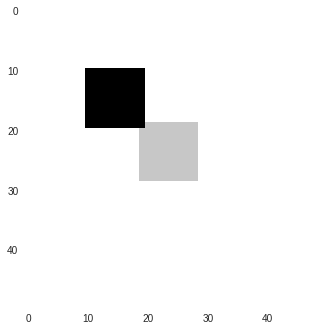

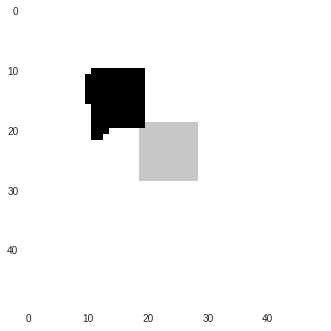

IndexError: ignored

In [4]:
a = Agents()
try_first = 0
for i in range(500):
  try_first = a.timestep_forward_series(try_first)
  if i%50==0:
    a.plot()

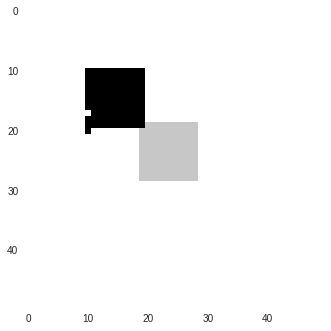

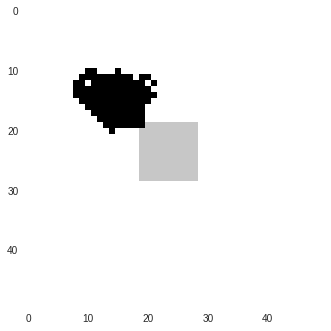

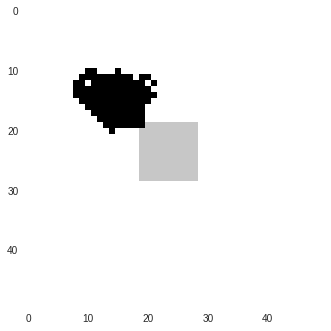

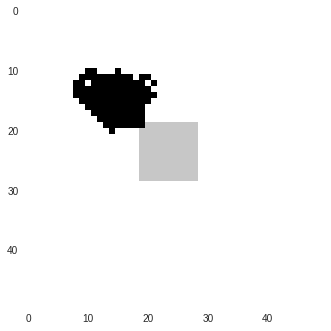

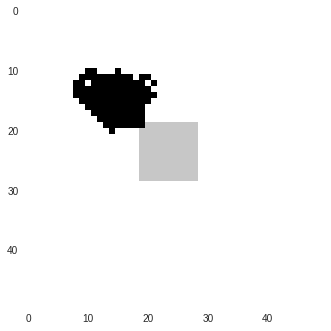

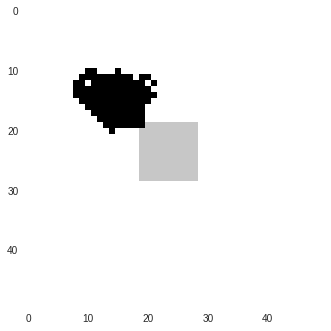

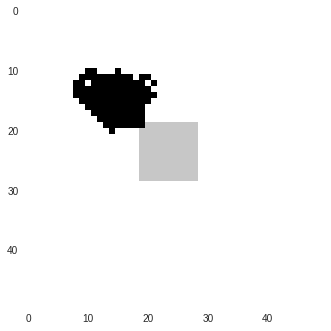

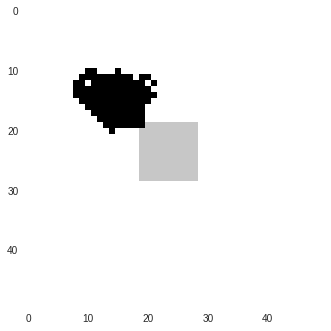

In [7]:
a = Agents()
for i in range(2000):
  a.timestep_forward_parallel()
  if i%250==0:
    a.plot()

In [3]:
not True or not True

False